In [49]:
# import neessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import warnings
from sklearn.cluster import KMeans
import os
from pyod.models.lof import LOF

# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [50]:
df_wind_to_append = []

# Load and append data for each farm
for farm in [1, 2, 3, 4, 5]:
    
    wind_to_append = pd.read_csv(f"../data/wind/enlitia_wind_farm_{farm}_data.csv")
    wind_to_append['farm'] = farm  # Add a 'farm' column with the farm number
    df_wind_to_append.append(wind_to_append)

# Concatenate the DataFrames and reset index
df_wind = pd.concat(df_wind_to_append, ignore_index=True)

print("Wind DataFrame:\n", df_wind.head(),"\n")


Wind DataFrame:
    asset_id              read_at  wind_speed  wind_direction  power_average  \
0        11  2021-01-01 00:00:00         8.3           296.0          802.0   
1        11  2021-01-01 00:10:00         8.9           306.0          832.0   
2        11  2021-01-01 00:20:00         8.1           298.0          666.0   
3        11  2021-01-01 00:30:00         7.9           298.0          541.0   
4        11  2021-01-01 00:40:00         8.1           296.0          625.0   

   rotation_average  exterior_temperature  nacelle_temperature  farm  
0             15.51                  -2.0                  9.0     1  
1             15.74                  -2.0                  9.0     1  
2             14.88                  -2.0                 10.0     1  
3             14.03                  -2.0                 10.0     1  
4             14.64                  -2.0                 10.0     1   



In [51]:
df_wind.to_csv("intermediate/wind/df_wind.csv", index=False)

In [52]:
df_wind.shape

(8367759, 9)

In [53]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8367759 entries, 0 to 8367758
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   asset_id              int64  
 1   read_at               object 
 2   wind_speed            float64
 3   wind_direction        float64
 4   power_average         float64
 5   rotation_average      float64
 6   exterior_temperature  float64
 7   nacelle_temperature   float64
 8   farm                  int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 574.6+ MB


In [54]:
df_wind["read_at"] = pd.to_datetime(df_wind["read_at"])

In [55]:
print(f"Head of Wind df: \n {df_wind.head()} \n")
print(f"Tail of Wind df: \n {df_wind.tail()} \n")

Head of Wind df: 
    asset_id             read_at  wind_speed  wind_direction  power_average  \
0        11 2021-01-01 00:00:00         8.3           296.0          802.0   
1        11 2021-01-01 00:10:00         8.9           306.0          832.0   
2        11 2021-01-01 00:20:00         8.1           298.0          666.0   
3        11 2021-01-01 00:30:00         7.9           298.0          541.0   
4        11 2021-01-01 00:40:00         8.1           296.0          625.0   

   rotation_average  exterior_temperature  nacelle_temperature  farm  
0             15.51                  -2.0                  9.0     1  
1             15.74                  -2.0                  9.0     1  
2             14.88                  -2.0                 10.0     1  
3             14.03                  -2.0                 10.0     1  
4             14.64                  -2.0                 10.0     1   

Tail of Wind df: 
          asset_id             read_at  wind_speed  wind_direction

In [56]:
print(f"Number of assets for Wind df: {df_wind['asset_id'].nunique()} \n")

Number of assets for Wind df: 71 



In [57]:
df_wind.describe()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
count,8.367759e+06,8367759,8.367759e+06,8.367759e+06,8.367759e+06,8.367759e+06,8.367758e+06,8.367758e+06,8.367759e+06
mean,1.297044e+02,2022-02-14 05:14:44.552669184,6.146998e+00,1.008878e+02,5.743852e+02,1.100961e+01,1.243242e+01,2.140831e+01,2.929581e+00
min,1.100000e+01,2021-01-01 00:00:00,-8.970000e+00,-1.070000e+03,-1.818000e+01,0.000000e+00,-4.499000e+01,-3.789000e+01,1.000000e+00
25%,2.900000e+01,2021-07-24 14:30:00,3.800000e+00,-1.090000e+02,6.700000e+01,7.790000e+00,7.000000e+00,1.600000e+01,2.000000e+00
50%,4.900000e+01,2022-02-14 05:10:00,5.700000e+00,1.150000e+02,2.890000e+02,1.118000e+01,1.102000e+01,2.100000e+01,3.000000e+00
75%,2.100000e+02,2022-09-06 20:00:00,8.000000e+00,3.140000e+02,8.800000e+02,1.487000e+01,1.700000e+01,2.700000e+01,4.000000e+00
max,5.120000e+02,2023-03-30 10:30:00,3.270000e+01,1.058000e+03,2.366000e+03,1.880000e+01,1.170000e+02,1.240000e+02,5.000000e+00
std,1.504828e+02,NaN,3.270634e+00,3.020807e+02,6.570261e+02,4.684451e+00,7.089474e+00,8.012069e+00,1.407463e+00


In [58]:
print(f"Duplicated values for the Wind df: {df_wind[df_wind.duplicated()]}")

Duplicated values for the Wind df: Empty DataFrame
Columns: [asset_id, read_at, wind_speed, wind_direction, power_average, rotation_average, exterior_temperature, nacelle_temperature, farm]
Index: []


In [59]:
print(f"NAs count for Wind")
print(df_wind.isna().sum(), "\n")

NAs count for Wind
asset_id                0
read_at                 0
wind_speed              0
wind_direction          0
power_average           0
rotation_average        0
exterior_temperature    1
nacelle_temperature     1
farm                    0
dtype: int64 



In [60]:
df_wind[df_wind["exterior_temperature"].isna()]

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
1043621,19,2022-12-01 21:00:00,12.5,-273.0,1962.0,17.8,NaN,NaN,1


#### Fill NA's

Fill NA's with the median of the median of the values for the same day and month at the same time, for the same asset. 

In [61]:
df_wind['read_at'] = pd.to_datetime(df_wind['read_at'])
filtered_df = df_wind[(df_wind['asset_id'] == 19) & 
                 (df_wind['read_at'].dt.time == pd.to_datetime('21:00:00').time()) & 
                 (df_wind['read_at'].dt.month == 12) & 
                 (df_wind['read_at'].dt.day == 1)] 
filtered_df

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
991062,19,2021-12-01 21:00:00,12.0,-52.0,2047.0,17.97,2.0,5.0,1
1043621,19,2022-12-01 21:00:00,12.5,-273.0,1962.0,17.80,NaN,NaN,1


In [62]:
df_wind.loc[df_wind["exterior_temperature"].isna(), "exterior_temperature"] = filtered_df["exterior_temperature"].median()
df_wind.loc[df_wind["nacelle_temperature"].isna(), "nacelle_temperature"] = filtered_df["nacelle_temperature"].median()

In [63]:
df_wind[(df_wind['asset_id'] == 19) & 
                 (df_wind['read_at'].dt.time == pd.to_datetime('21:00:00').time()) & 
                 (df_wind['read_at'].dt.month == 12) & 
                 (df_wind['read_at'].dt.day == 1)] 

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
991062,19,2021-12-01 21:00:00,12.0,-52.0,2047.0,17.97,2.0,5.0,1
1043621,19,2022-12-01 21:00:00,12.5,-273.0,1962.0,17.80,2.0,5.0,1


### Features distribution

In [64]:
filtered_df_wind = df_wind.iloc[:, 2:-1]
print(filtered_df_wind.columns)

filtered_df_wind.to_csv("intermediate/wind/filtered_df_wind.csv", index=False)

Index(['wind_speed', 'wind_direction', 'power_average', 'rotation_average',
       'exterior_temperature', 'nacelle_temperature'],
      dtype='object')



Boxplots for the Wind df:


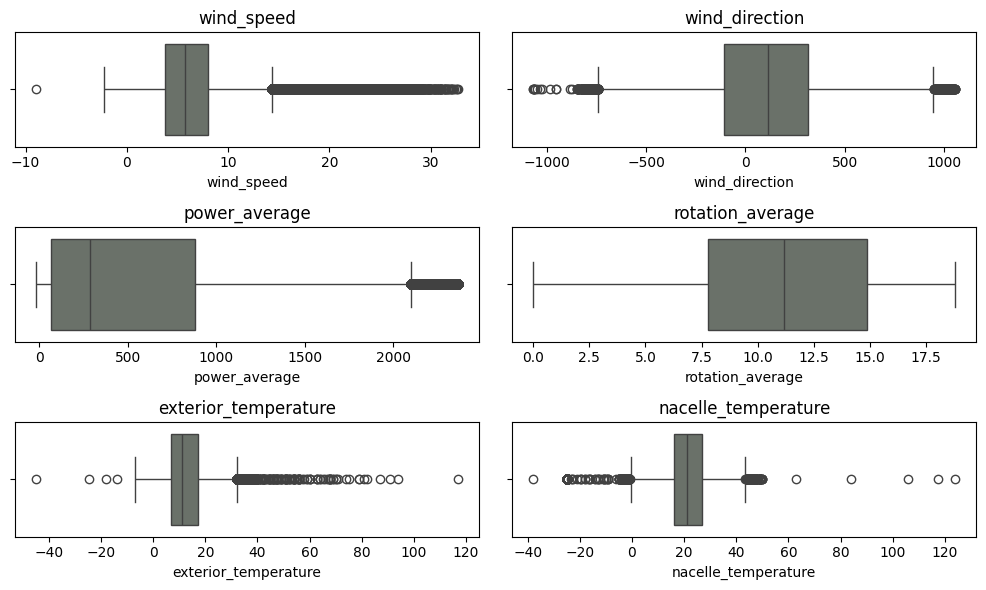

In [17]:
print(f"\nBoxplots for the Wind df:")
num_cols = len(filtered_df_wind.columns)
num_rows = (num_cols + 1) // 2  
fig, axes = plt.subplots(num_rows, 2, figsize=(10, num_rows*2))

axes = axes.flatten()

for i, feature in enumerate(filtered_df_wind.columns):
    if i < num_cols:  
        sns.boxplot(x=filtered_df_wind[feature], color='#697268', ax=axes[i])
        axes[i].set_title(feature)  
plt.tight_layout() 
plt.show()

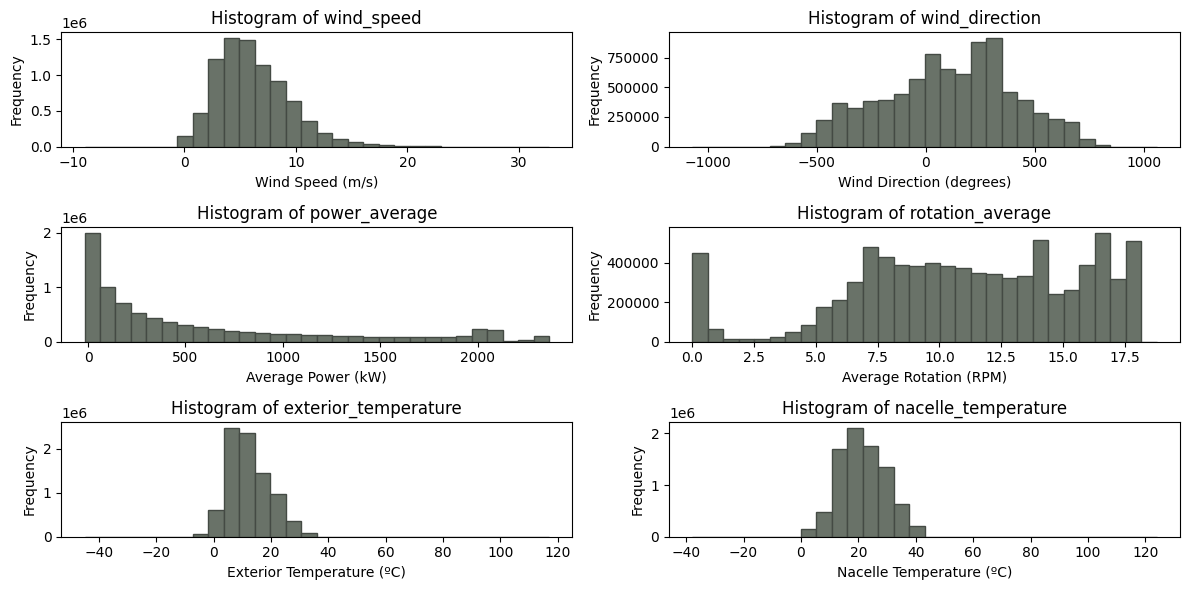

In [18]:
# Plotting the histograms
subset = df_wind.iloc[:, 2:-1]
column_names = ["Wind Speed (m/s)", "Wind Direction (degrees)","Average Power (kW)", "Average Rotation (RPM)", "Exterior Temperature (ºC)", "Nacelle Temperature (ºC)"]

fig, axs = plt.subplots(int(len(column_names)/2), 2, figsize=(12, 6))  

for i, column in enumerate(subset.columns):
    row_index = i // 2  # Calculate row index
    col_index = i % 2   # Calculate column index
    axs[row_index, col_index].hist(subset[column], bins=30, color='#697268', edgecolor='#444a44') 
    axs[row_index, col_index].set_xlabel(column_names[i])
    axs[row_index, col_index].set_ylabel('Frequency')
    axs[row_index, col_index].set_title(f'Histogram of {column}')
    axs[row_index, col_index].grid(False)

plt.tight_layout()  
plt.show()

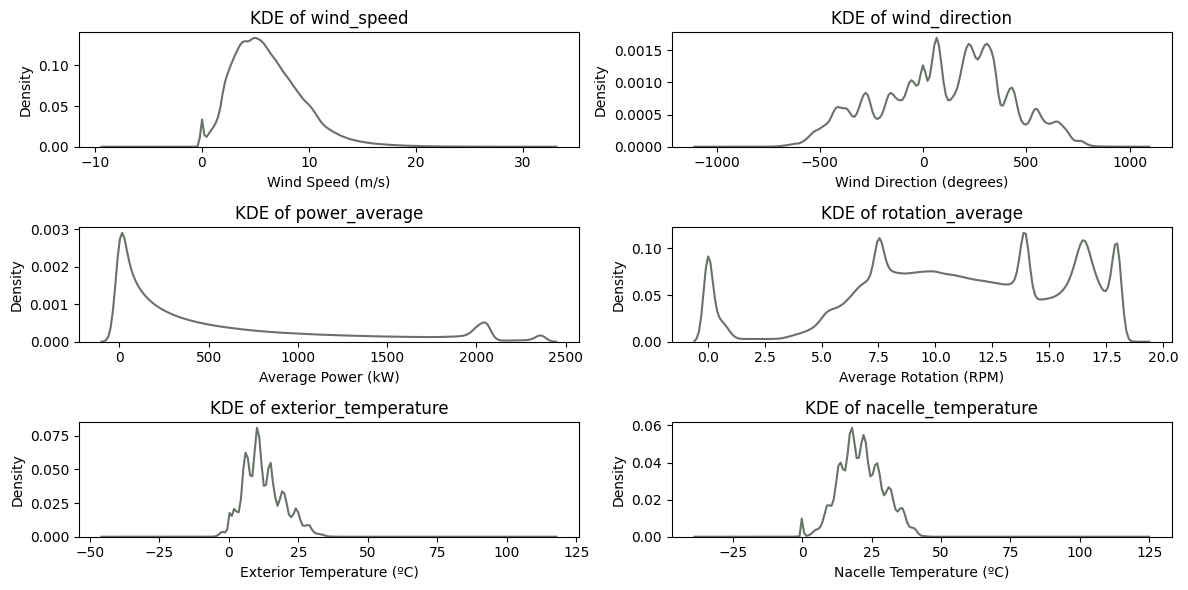

In [19]:
xlabels_names = ["Wind Speed (m/s)", "Wind Direction (degrees)", "Average Power (kW)", "Average Rotation (RPM)", "Exterior Temperature (ºC)", "Nacelle Temperature (ºC)"]
subset = df_wind.iloc[:, 2:-1]

fig, axs = plt.subplots(int(len(xlabels_names)/2), 2, figsize=(12, 6))

for i, column in enumerate(subset.columns):
    row_index = i // 2  
    col_index = i % 2  
    sns.kdeplot(subset[column], ax=axs[row_index, col_index], color='#697268')
    axs[row_index, col_index].set_xlabel(xlabels_names[i])
    axs[row_index, col_index].set_ylabel('Density')
    axs[row_index, col_index].set_title(f'KDE of {column}')
    axs[row_index, col_index].grid(False)

plt.tight_layout()
plt.show()


In [20]:
df_wind = pd.read_csv("intermediate/wind/df_wind.csv")
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1
1,11,2021-01-01 00:10:00,8.9,306.0,832.0,15.74,-2.0,9.0,1
2,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1
3,11,2021-01-01 00:30:00,7.9,298.0,541.0,14.03,-2.0,10.0,1
4,11,2021-01-01 00:40:00,8.1,296.0,625.0,14.64,-2.0,10.0,1


In [21]:
df_wind_pairplot = df_wind.iloc[:, 0:-1].copy() 
df_wind_pairplot

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature
0,11,2021-01-01 00:00:00,8.3,296.0,802.00,15.51,-2.0,9.0
1,11,2021-01-01 00:10:00,8.9,306.0,832.00,15.74,-2.0,9.0
2,11,2021-01-01 00:20:00,8.1,298.0,666.00,14.88,-2.0,10.0
3,11,2021-01-01 00:30:00,7.9,298.0,541.00,14.03,-2.0,10.0
4,11,2021-01-01 00:40:00,8.1,296.0,625.00,14.64,-2.0,10.0
...,...,...,...,...,...,...,...,...
8367754,512,2023-03-30 09:50:00,10.7,224.0,1984.49,13.93,11.8,16.1
8367755,512,2023-03-30 10:00:00,9.7,224.0,1826.37,13.95,12.2,16.6
8367756,512,2023-03-30 10:10:00,9.2,224.0,1567.75,13.74,12.2,17.4
8367757,512,2023-03-30 10:20:00,7.3,224.0,816.03,12.25,12.5,17.5


## Feature Relations

In [22]:
# df_wind=pd.read_csv("intermediate/wind/df_wind.csv")
xlabels_names = ["Wind Speed (m/s)", "Wind Direction (degrees)", "Average Power (kW)", "Average Rotation (RPM)", "Exterior Temperature (ºC)", "Nacelle Temperature (ºC)"]

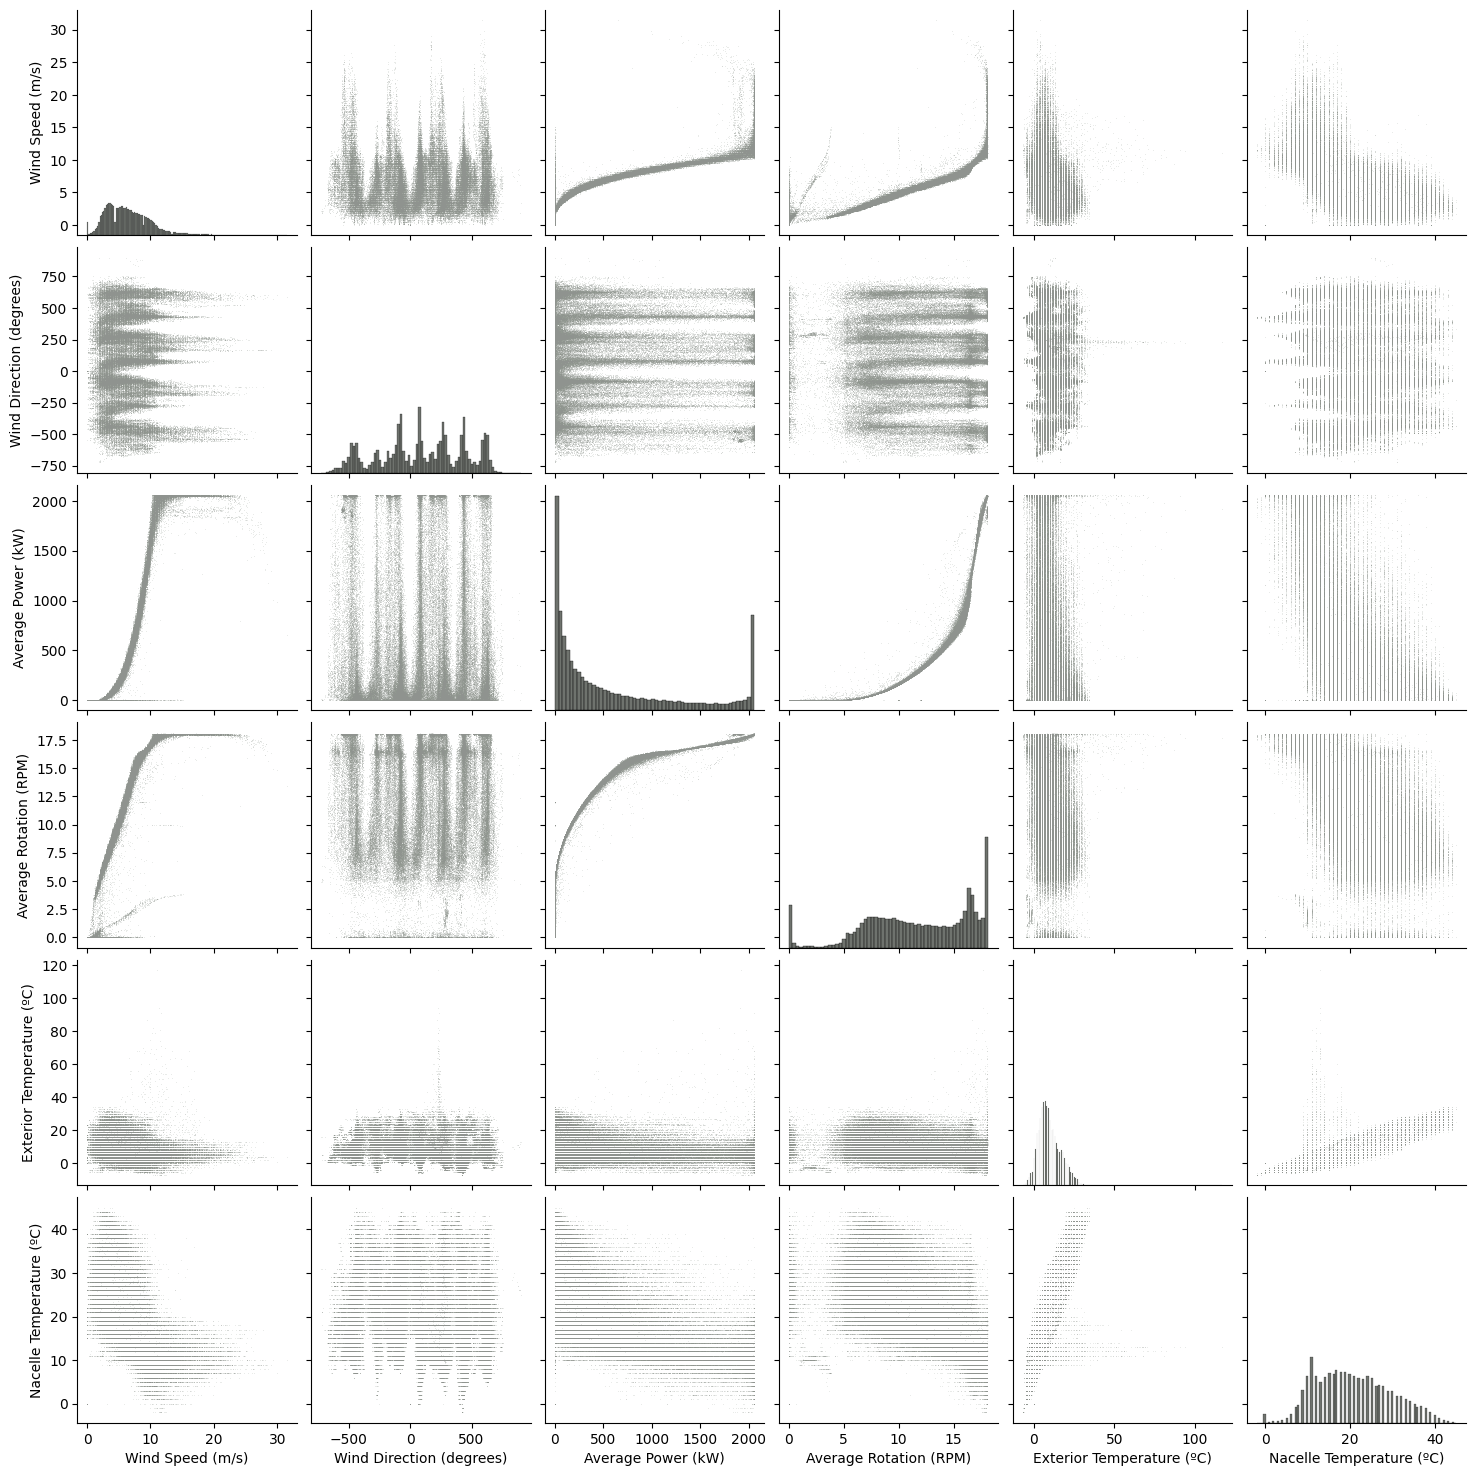

In [23]:
df_wind_pairplot = df_wind.copy()    

asset = df_wind_pairplot["asset_id"].unique()[:1]

subset = df_wind_pairplot[df_wind_pairplot["asset_id"].isin(asset)]
subset = subset.iloc[:,2:-1]
subset.columns = xlabels_names

# custom_palette = ['#3F443E', '#8C4843', '#88292F', '#C4DACF', '#EDEEC9']


sns.pairplot(subset,plot_kws={'s': 0.1, 'color':'#697268'}, diag_kws={'color': '#3F443E'})

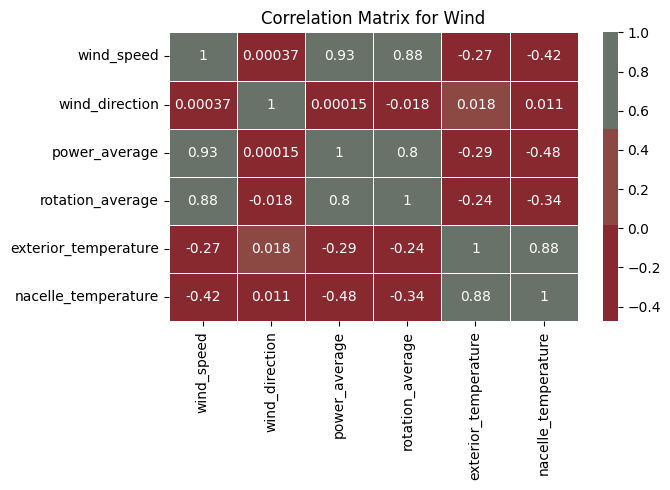

In [24]:
# Calculate the correlation matrix
my_colors = ['#88292F', '#8C4843', '#697268']
sns.set_palette(my_colors)


corr_matrix = filtered_df_wind.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap=my_colors, linewidths=0.5)
plt.title(f'Correlation Matrix for Wind')
plt.tight_layout()
plt.show()

wind_direction, power_average, exterior_temperature

Explore variables with the highest relation with power average:

Wind speed vs power average;

And rotation average vs power average;

NOTE: A nacelle is a cover housing that houses all of the generating components in a wind turbine, including the generator, gearbox, drive train, and brake assembly.

# Outliers

In the distribuition analysis, was possible to see that the wind speed goes below 0, what can't be normal.
 
Also, begin measured in degrees, it's not normal that the wind direction goes below -365 and above 365.  

In [65]:
print(f"Number of values with wind speed below 0: {len(df_wind[df_wind['wind_speed']<0])}")
df_wind.loc[df_wind["wind_speed"]<0]

Number of values with wind speed below 0: 13


,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
7299040,53,2023-02-02 18:50:00,-0.06,100.83,-1.25,0.30,8.77,16.74,5
7589194,56,2021-11-19 09:50:00,-8.97,18.34,-0.23,0.22,8.40,16.24,5
7594951,56,2021-12-29 09:20:00,-0.02,202.73,-1.42,0.07,11.46,24.18,5
7595000,56,2021-12-29 17:30:00,-0.37,243.34,-0.01,0.00,12.28,18.97,5
7595047,56,2021-12-30 01:20:00,-0.03,122.41,54.32,3.57,12.12,19.44,5
7595423,56,2022-01-01 16:00:00,-2.27,181.78,-1.24,0.25,16.80,24.59,5
7595546,56,2022-01-02 12:30:00,-0.60,244.72,8.80,2.81,11.80,22.66,5
7595567,56,2022-01-02 16:00:00,-0.90,243.34,-0.11,0.00,13.60,21.76,5
7595601,56,2022-01-02 21:40:00,-0.60,172.00,0.00,0.00,12.20,16.92,5
7595603,56,2022-01-02 22:00:00,-0.40,172.00,-0.13,0.00,12.20,16.93,5


In [66]:
print(f"Number of values with wind speed equal to 0: {len(df_wind[df_wind['wind_speed']==0])}")
df_wind.loc[df_wind["wind_speed"]==0]

Number of values with wind speed equal to 0: 89696


,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
11924,11,2021-03-24 19:20:00,0.0,0.0,0.0,0.0,4.0,18.0,1
11926,11,2021-03-24 19:40:00,0.0,0.0,0.0,0.0,3.0,16.0,1
11927,11,2021-03-24 19:50:00,0.0,0.0,0.0,0.0,3.0,16.0,1
11928,11,2021-03-24 20:00:00,0.0,0.0,0.0,0.0,3.0,16.0,1
11929,11,2021-03-24 20:10:00,0.0,0.0,0.0,0.0,3.0,16.0,1
...,...,...,...,...,...,...,...,...,...
8365631,512,2023-03-15 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,5
8365632,512,2023-03-15 16:10:00,0.0,0.0,0.0,0.0,0.0,0.0,5
8365633,512,2023-03-15 16:20:00,0.0,0.0,0.0,0.0,0.0,0.0,5
8365634,512,2023-03-15 16:30:00,0.0,0.0,0.0,0.0,0.0,0.0,5


In [67]:
out_of_range_rows = df_wind[(df_wind['wind_direction'] < -365) | (df_wind['wind_direction'] > 365)]

print(f"Number of values with wind direction equal to 0: {len(out_of_range_rows)}")
out_of_range_rows

Number of values with wind direction equal to 0: 2230573


,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
220,11,2021-01-02 12:40:00,2.0,389.0,0.0,1.18,5.0,19.0,1
221,11,2021-01-02 12:50:00,1.9,374.0,0.0,3.35,5.0,19.0,1
222,11,2021-01-02 13:00:00,2.1,376.0,1.0,5.06,5.0,20.0,1
231,11,2021-01-02 14:30:00,1.1,408.0,0.0,0.12,5.0,21.0,1
232,11,2021-01-02 14:40:00,1.1,403.0,0.0,0.07,6.0,22.0,1
...,...,...,...,...,...,...,...,...,...
6953268,415,2023-03-28 22:10:00,7.4,555.0,705.0,14.82,17.0,25.0,4
6953269,415,2023-03-28 22:20:00,7.3,555.0,648.0,14.68,17.0,25.0,4
6953270,415,2023-03-28 22:30:00,6.9,553.0,584.0,14.15,17.0,25.0,4
6953271,415,2023-03-28 22:40:00,7.4,562.0,653.0,14.39,17.0,25.0,4


In [68]:
# Create a boolean mask indicating rows where wind_direction is outside the range (-365, 365)
out_of_range_rows = (df_wind['wind_direction'] < -365) | (df_wind['wind_direction'] > 365) | (df_wind['wind_speed']<=0)

# Filter the DataFrame df_wind to keep only the rows where wind_direction is within the range
df_wind = df_wind[~out_of_range_rows].reset_index(drop=True)

# Print the filtered DataFrame
print(f"New length of wind df: {len(df_wind)} \n {df_wind}")


New length of wind df: 6047675 
          asset_id             read_at  wind_speed  wind_direction  \
0              11 2021-01-01 00:00:00         8.3           296.0   
1              11 2021-01-01 00:10:00         8.9           306.0   
2              11 2021-01-01 00:20:00         8.1           298.0   
3              11 2021-01-01 00:30:00         7.9           298.0   
4              11 2021-01-01 00:40:00         8.1           296.0   
...           ...                 ...         ...             ...   
6047670       512 2023-03-30 09:50:00        10.7           224.0   
6047671       512 2023-03-30 10:00:00         9.7           224.0   
6047672       512 2023-03-30 10:10:00         9.2           224.0   
6047673       512 2023-03-30 10:20:00         7.3           224.0   
6047674       512 2023-03-30 10:30:00         7.4           233.0   

         power_average  rotation_average  exterior_temperature  \
0               802.00             15.51                  -2.0   
1     

In [69]:
df_wind.to_csv("intermediate/wind/df_length_to_compare.csv", index=False)

In [ ]:
df_wind = pd.read_csv("intermediate/wind/df_length_to_compare.csv")

In [41]:
def percent_removed(original_df, cleaned_df):
    percentage = round((len(original_df)/len(cleaned_df)-1)*100,2)
    return percentage

In [42]:
original_df_wind = pd.read_csv('intermediate/wind/df_wind.csv')

In [43]:
print(f'Percentage of out of range values for data speed or direction: {percent_removed(original_df_wind, df_wind)}%')

Percentage of out of range values for data speed or direction: 38.36%


wind speed vs power average

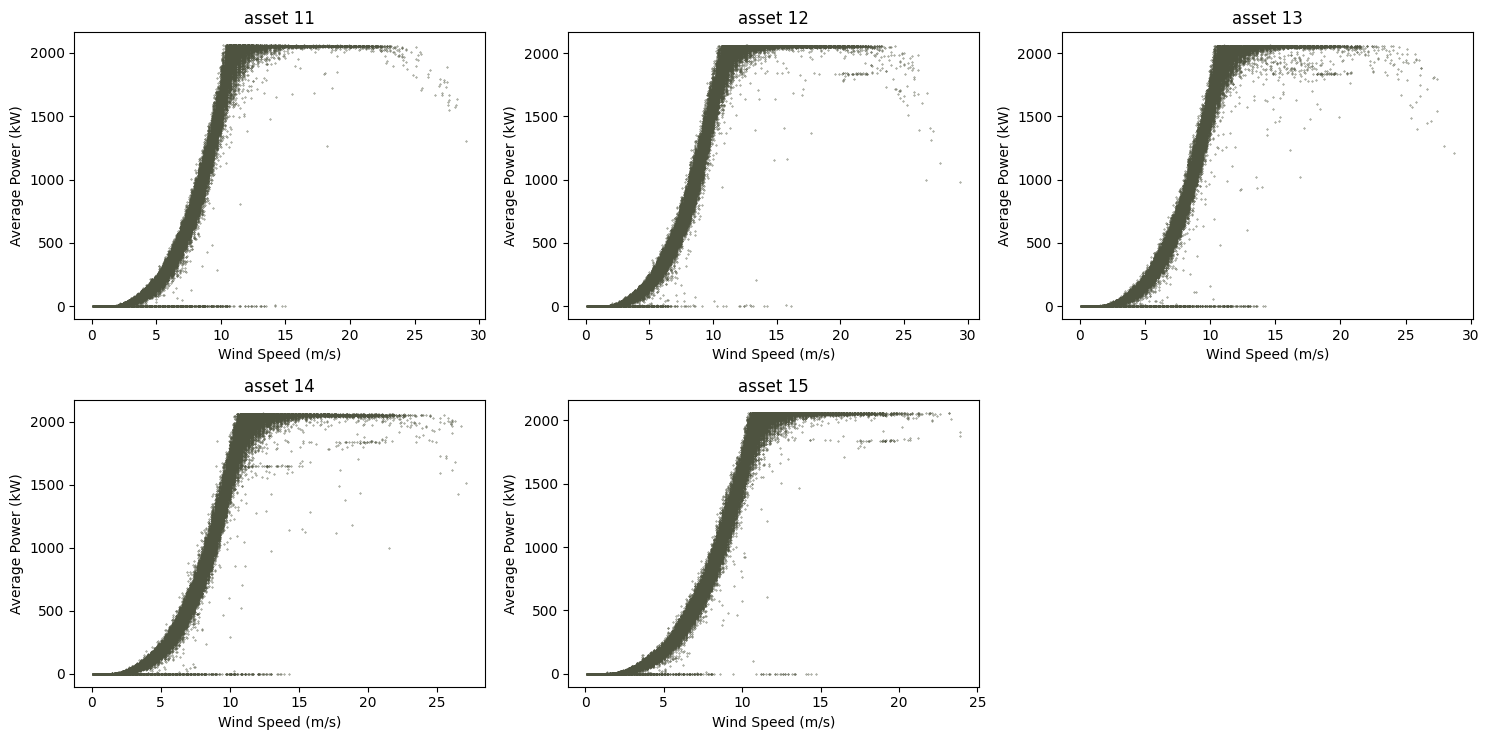

In [22]:
plot = 1
assets = df_wind["asset_id"].unique()[:5]
n_plots = 5
plt.figure(figsize=(n_plots*3, n_plots*1.5))
for asset, subset in df_wind[df_wind["asset_id"].isin(assets)].groupby("asset_id"):
    plt.subplot(2, 3, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Average Power (kW)')
    plt.scatter(subset["wind_speed"], subset["power_average"], c="#4E5340", s=0.1)
    plot += 1
plt.tight_layout()
plt.show()

test the DBSCAN method to identify outliers:

Number of outliers for Asset 11: 2911
Number of outliers for Asset 12: 2384
Number of outliers for Asset 13: 3133
Number of outliers for Asset 14: 2760
Number of outliers for Asset 15: 2361


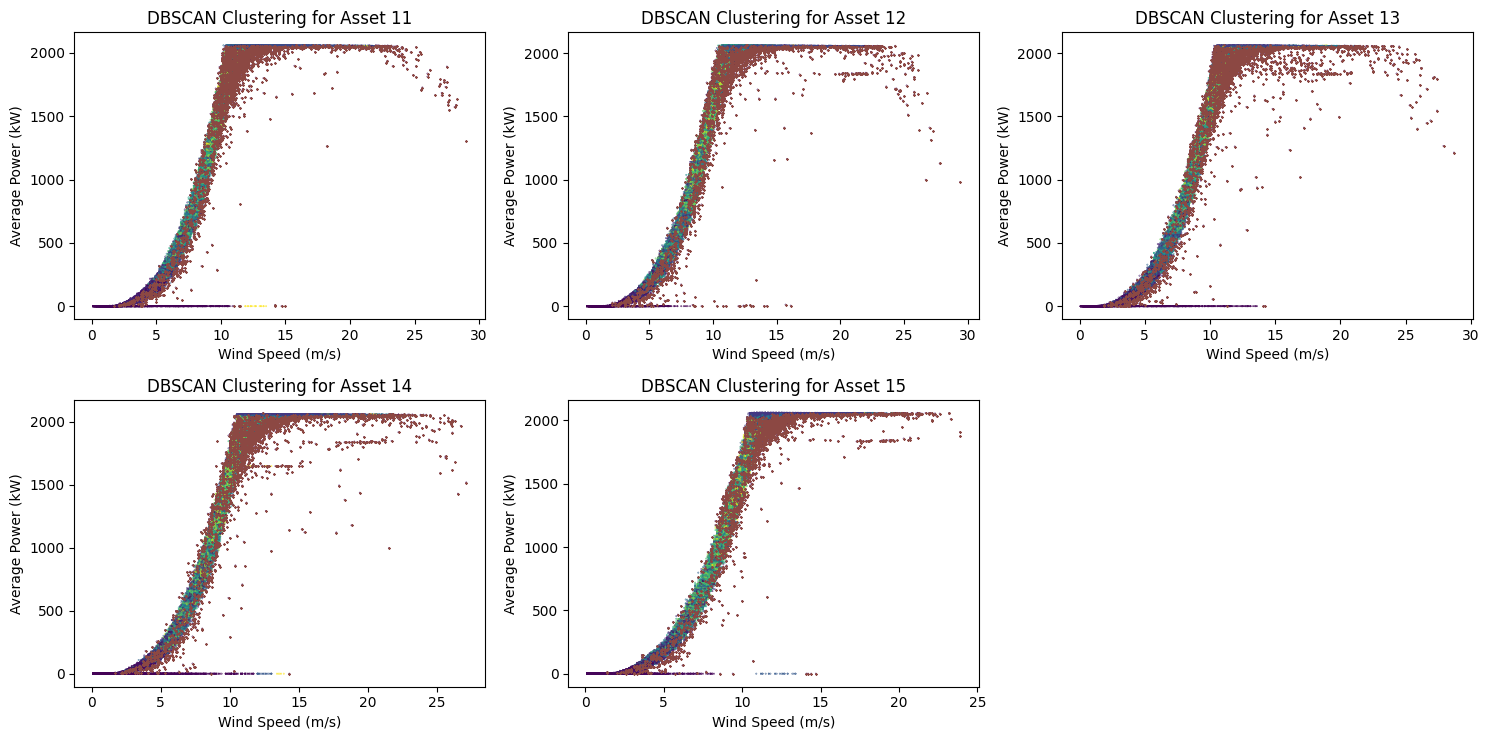

In [34]:
# Define the DBSCAN parameters
eps = 0.3
min_samples = 5

n_plots = 5

plt.figure(figsize=(n_plots*3, n_plots*1.5))

# Iterate over the first 5 assets
for plot, asset_id in enumerate(df_wind['asset_id'].unique()[:n_plots], start=1):
    # Filter the data for the current asset
    filtered_data = df_wind[df_wind['asset_id'] == asset_id][['wind_speed', 'power_average']]

    # Create the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the data
    dbscan.fit(filtered_data)

    # Get the labels of the data points
    labels = dbscan.labels_

    # Identify the outliers
    outliers = np.where(labels == -1)[0]

    # Print the number of outliers
    print(f"Number of outliers for Asset {asset_id}:", len(outliers))

    plt.subplot(2, 3, plot)

    # Plot the data with the outliers highlighted
    plt.scatter(filtered_data['wind_speed'], filtered_data['power_average'], c=labels, label = "Remaining Points" , s=0.1)
    plt.scatter(filtered_data.iloc[outliers, 0], filtered_data.iloc[outliers, 1], c="#8C4843", marker="x", label = "Outlier",s=1)
    plt.title(f'DBSCAN Clustering for Asset {asset_id}')
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Average Power (kW)')

# Adjust layout and show plot
plt.tight_layout()
plt.show()



### Find the sigmoid curve

In [70]:
# Define the sigmoid function
def sigmoid(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Calculate the derivative of the sigmoid function
def sigmoid_derivative(x, L, k, x0):
    return (L * k * np.exp(-k * (x - x0))) / ((1 + np.exp(-k * (x - x0))) ** 2)

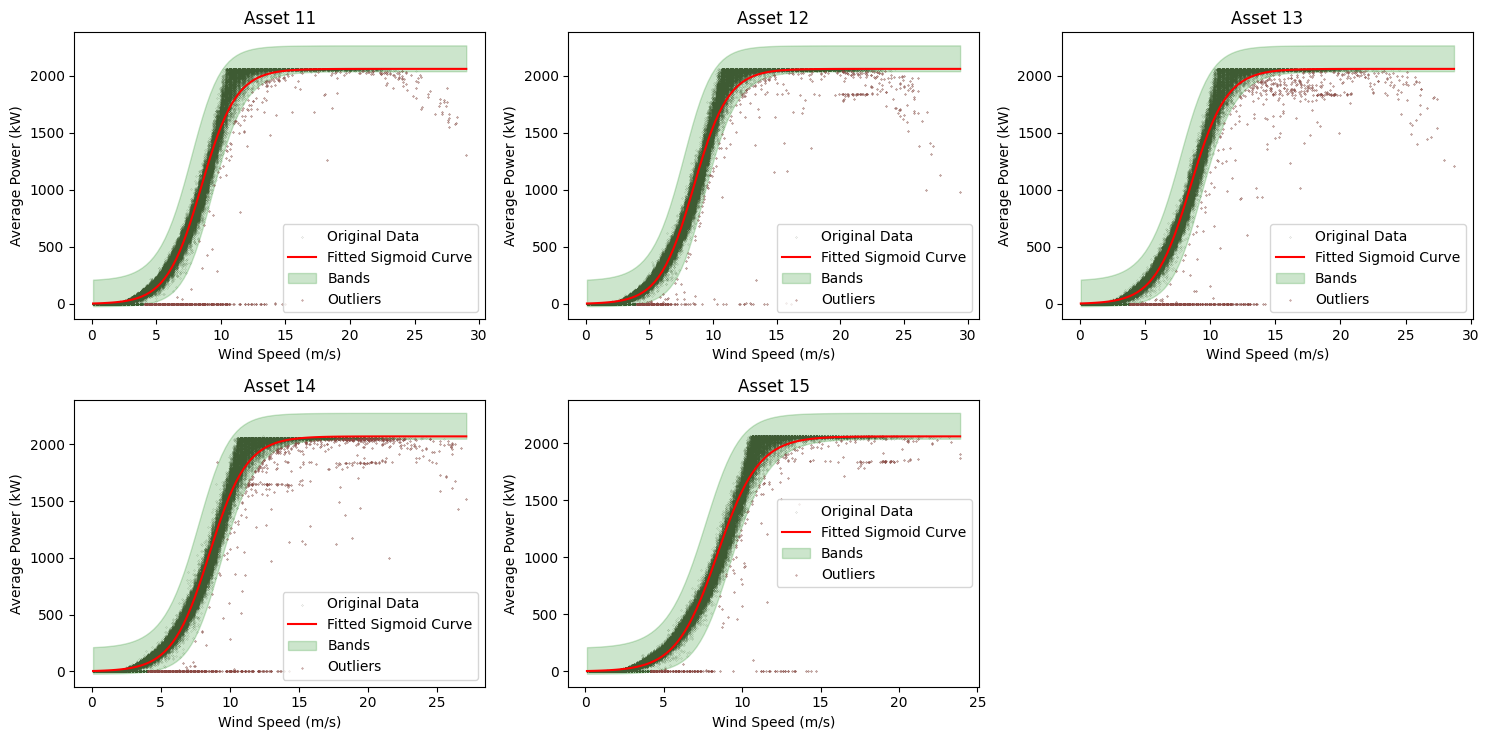

In [71]:
# Prepare the data for the first 5 assets
assets = df_wind["asset_id"].unique()[:5]  # Select the first 5 assets
n_plots = len(assets)
# Create a subplot grid with 2 rows and 3 columns
plt.figure(figsize=(n_plots*3, n_plots*1.5))

for i, asset_id in enumerate(assets, 1):
    plt.subplot(2, 3, i)

    df_wind_sigmoid = df_wind[df_wind["asset_id"] == asset_id]
    wind_speed = df_wind_sigmoid['wind_speed']
    power = df_wind_sigmoid['power_average']

    # Perform curve fitting with an upper bound for L
    # Adjust the upper_bound_L value as needed
    upper_bound_L = max(power)  # Use the maximum value of power as the upper bound for L
    popt, pcov = curve_fit(sigmoid, wind_speed, power, bounds=([0, 0, -np.inf], [upper_bound_L, np.inf, np.inf]))

    # Retrieve the optimized parameters
    L, k, x0 = popt

    # Generate points for the fitted sigmoid curve
    x_fit = np.linspace(min(wind_speed), max(wind_speed), 100)
    y_fit = sigmoid(x_fit, *popt)

    # Calculate the derivative values
    derivative_values = sigmoid_derivative(x_fit, *popt)

    # Calculate the band width based on the derivative values
    band_width = np.abs(derivative_values)  # Adjust the factor to control the width

    # Calculate upper and lower bands
    upper_band = y_fit + band_width + max(power) * 0.1
    lower_band = y_fit - (band_width + max(power)*0.01)

    upper_band_interp = interp1d(x_fit, upper_band)(wind_speed)
    lower_band_interp = interp1d(x_fit, lower_band)(wind_speed)

    # Identify outliers outside the interpolated bands
    outliers = (power > upper_band_interp) | (power < lower_band_interp)

    # Plot the original data points
    plt.scatter(wind_speed, power, label='Original Data', s=0.01, color='#4E5340')

    # Plot the fitted sigmoid curve
    plt.plot(x_fit, y_fit, color='red', label='Fitted Sigmoid Curve')

    # Plot the upper and lower bands
    plt.fill_between(x_fit, upper_band, lower_band, color='green', alpha=0.2, label='Bands')

    # Highlight outliers
    plt.scatter(wind_speed[outliers], power[outliers], color='#8C4843', label='Outliers', s=0.1)

    # Add labels and legend
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Average Power (kW)')
    plt.title(f'Asset {asset_id}')
    plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [72]:
# Initialize an empty DataFrame to store the filtered data
filtered_data = pd.DataFrame()

# Group the DataFrame by "asset_id"
grouped = df_wind.groupby("asset_id")

for asset_id, group_df in grouped:

    wind_speed = group_df['wind_speed']
    power = group_df['power_average']

    # Perform curve fitting with an upper bound for L
    # Adjust the upper_bound_L value as needed
    upper_bound_L = max(power)  # Use the maximum value of power as the upper bound for L
    popt, pcov = curve_fit(sigmoid, wind_speed, power, bounds=([0, 0, -np.inf], [upper_bound_L, np.inf, np.inf]))

    # Retrieve the optimized parameters
    L, k, x0 = popt

    # Generate points for the fitted sigmoid curve
    x_fit = np.linspace(min(wind_speed), max(wind_speed), 100)
    y_fit = sigmoid(x_fit, *popt)

    # Calculate the derivative values
    derivative_values = sigmoid_derivative(x_fit, *popt)

    # Calculate the band width based on the derivative values
    band_width = np.abs(derivative_values)  # Adjust the factor to control the width

    # Calculate upper and lower bands
    upper_band = y_fit + band_width + max(power) * 0.1
    lower_band = y_fit - (band_width + max(power)*0.01)

    upper_band_interp = interp1d(x_fit, upper_band)(wind_speed)
    lower_band_interp = interp1d(x_fit, lower_band)(wind_speed)

    # Identify outliers outside the interpolated bands
    outliers = (power > upper_band_interp) | (power < lower_band_interp)

    # Concatenate the filtered subset to the overall filtered DataFrame
    filtered_data = pd.concat([filtered_data, group_df[~outliers]])

filtered_data = filtered_data[filtered_data["power_average"] > 0]

filtered_data.to_csv("intermediate/wind/df_without_out.csv")


In [73]:
filtered_data = pd.read_csv("intermediate/wind/df_without_out.csv")

In [74]:
df_wind = filtered_data.loc[:,"asset_id":]

In [75]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1
1,11,2021-01-01 00:10:00,8.9,306.0,832.0,15.74,-2.0,9.0,1
2,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1
3,11,2021-01-01 00:30:00,7.9,298.0,541.0,14.03,-2.0,10.0,1
4,11,2021-01-01 00:40:00,8.1,296.0,625.0,14.64,-2.0,10.0,1


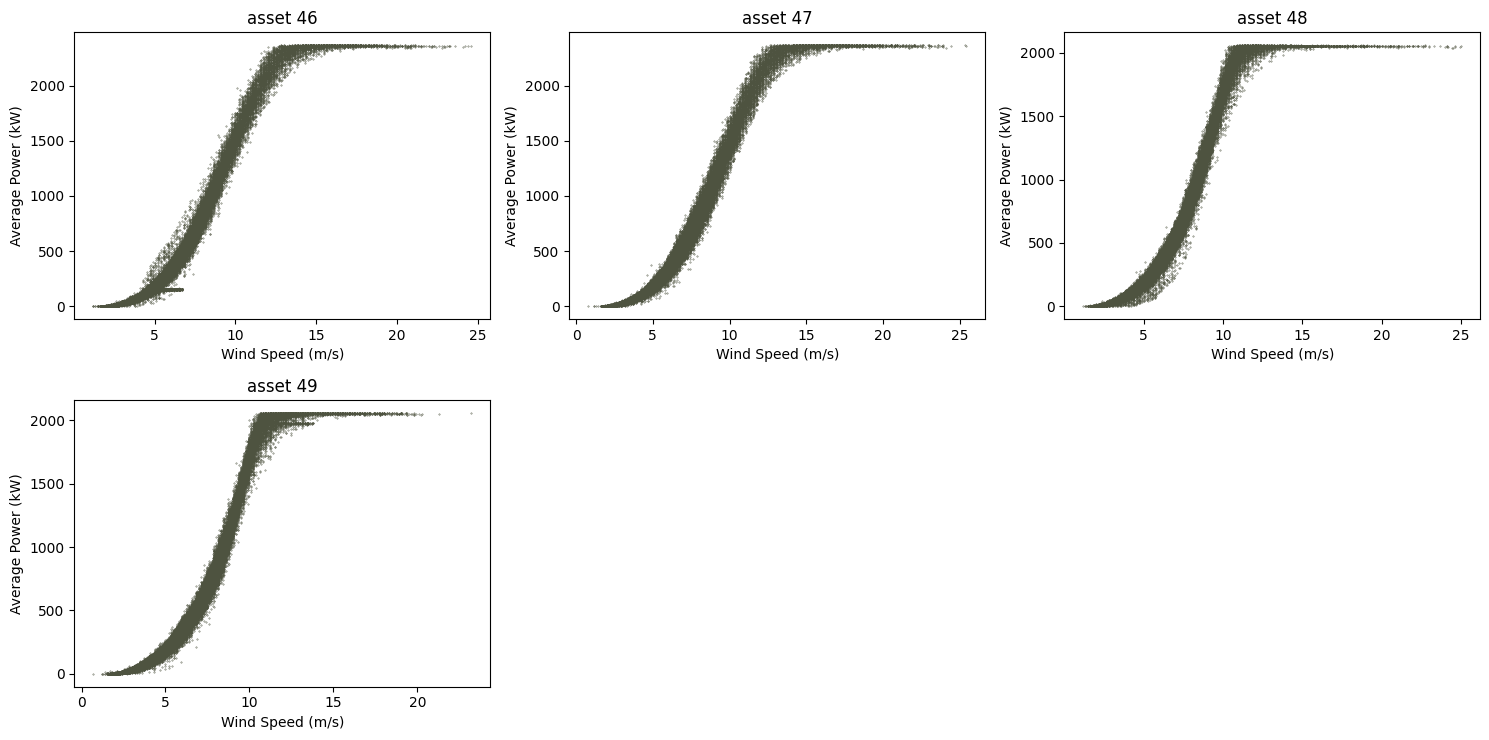

In [76]:
plot = 1
assets = df_wind["asset_id"].unique()[32:36]
n_plots = 5
plt.figure(figsize=(n_plots*3, n_plots*1.5))
for asset, subset in df_wind[df_wind["asset_id"].isin(assets)].groupby("asset_id"):
    plt.subplot(2, 3, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Average Power (kW)')
    plt.scatter(subset["wind_speed"], subset["power_average"], c="#4E5340", s=0.1)
    plot += 1
plt.tight_layout()
plt.show()

Try mean-square error:

/tmp/ipykernel_7038/4058129156.py:18: RuntimeWarning: invalid value encountered in scalar divide
  mean_square_deviation = np.sqrt(((group_df['power_average'] - mean_power) ** 2).sum() / (n - 1))


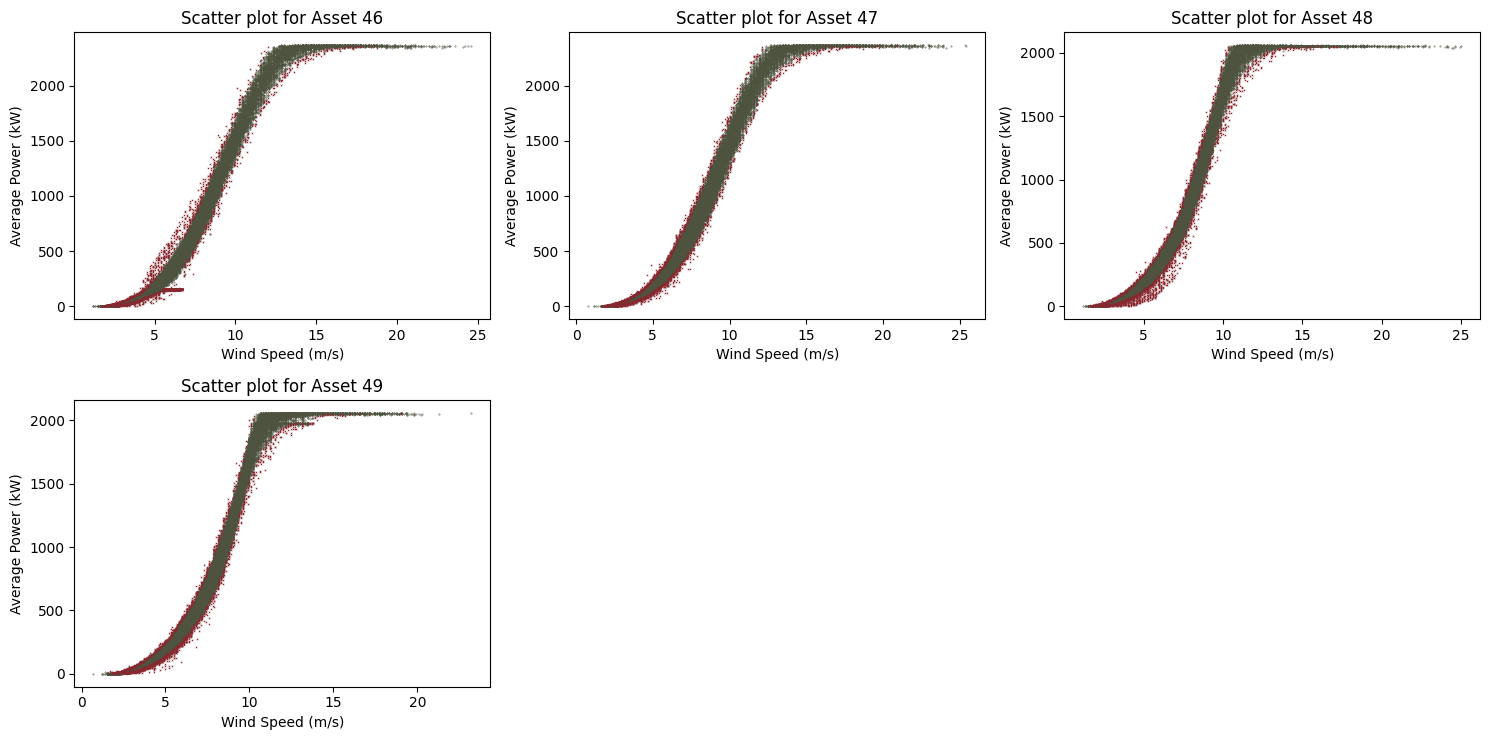

In [77]:
# Create an empty list to store outliers for each asset
outliers_list = []

assets = df_wind["asset_id"].unique()[32:36]

n_plots = 5

plt.figure(figsize=(n_plots*3, n_plots*1.5))

# Group the data by wind speed intervals
wind_speed_intervals = pd.cut(df_wind['wind_speed'], bins=np.arange(0, df_wind['wind_speed'].max() + 0.1, 0.1))
grouped_df = df_wind.groupby([wind_speed_intervals, "asset_id"])

for (wind_speed_interval, asset_id), group_df in grouped_df:
    # Calculate mean power and within-group mean square deviation
    mean_power = group_df['power_average'].mean()
    n = len(group_df)
    mean_square_deviation = np.sqrt(((group_df['power_average'] - mean_power) ** 2).sum() / (n - 1))
    
    # Select the mean square deviation multiplier
    mean_sq_dev_multiplier = 2.15
    
    # Threshold for identifying outliers
    threshold = mean_sq_dev_multiplier * mean_square_deviation 

    # Filter out outliers
    outliers = group_df[(group_df['power_average'] - mean_power).abs() > threshold]

    # Append outliers for each asset to the outliers list
    outliers_list.append(outliers)

# Plot the data points with outliers in a different color
inliers_df = df_wind.drop(pd.concat(outliers_list).index)

# Iterate over the selected assets
for i, asset_id in enumerate(assets, 1):
    plt.subplot(2, 3, i)
    asset_inliers = inliers_df[inliers_df["asset_id"] == asset_id]
    asset_outliers = pd.concat([outliers[outliers["asset_id"] == asset_id] for outliers in outliers_list])
    
    plt.scatter(asset_inliers["wind_speed"], asset_inliers["power_average"], c="#4E5340", s=0.1)
    plt.scatter(asset_outliers["wind_speed"], asset_outliers["power_average"], c="#88292F", s=0.1, marker="x")
    
    plt.title(f'Scatter plot for Asset {asset_id}')
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Average Power (kW)')
    #plt.legend(['Inliers', 'Outliers'])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [78]:
inliers_df = inliers_df.reset_index().loc[:,"asset_id":]
inliers_df.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1


In [79]:
# Store mean-square inliers:
inliers_df.to_csv('intermediate/wind/MSE_inliers.csv', index=False)

In [80]:
df_wind = inliers_df

## Try K-Means, DBSCAN and KLOF to try and clean even more the PC:

### K-Means

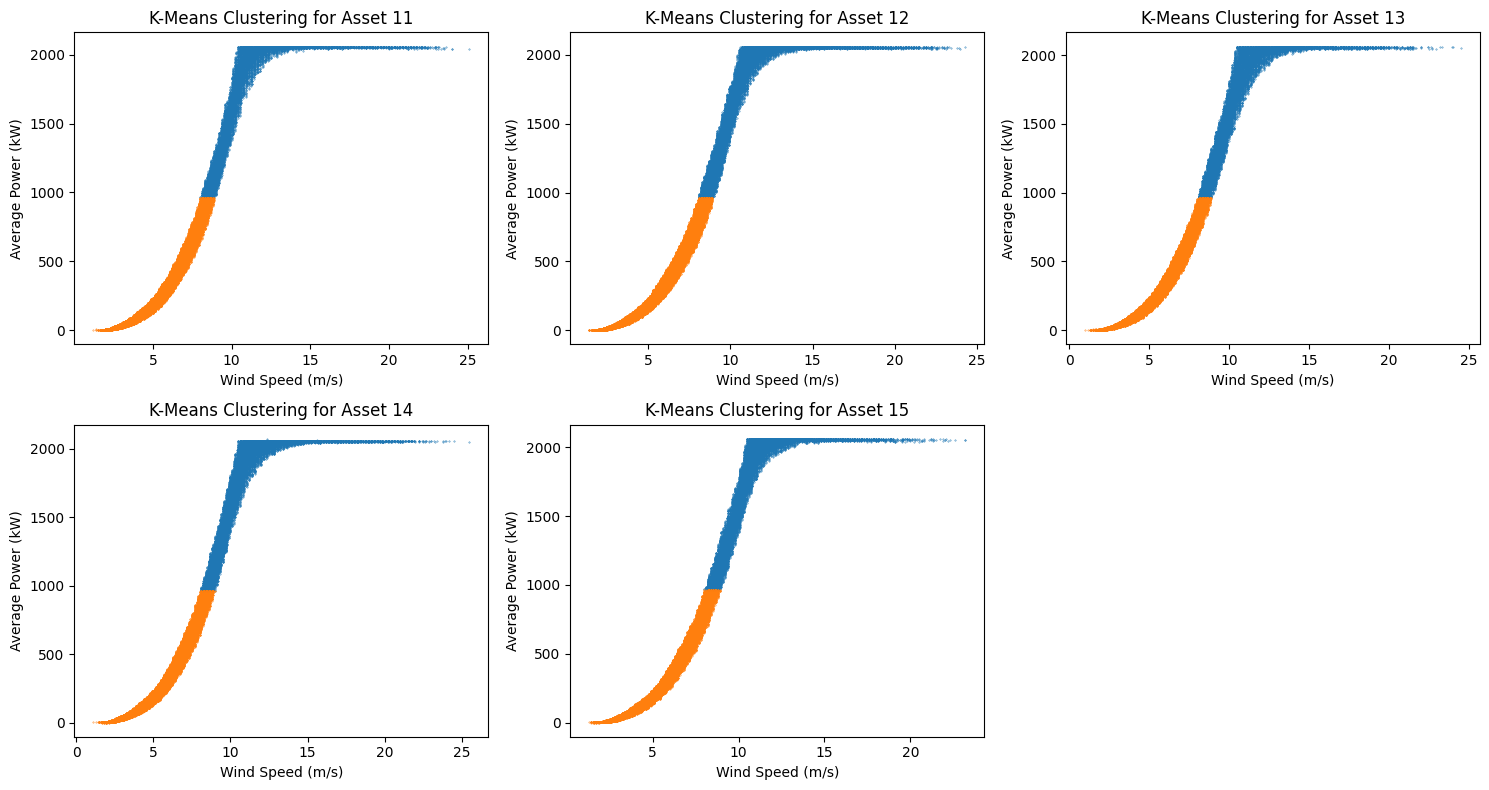

In [81]:
# Define the number of clusters for k-means
n_clusters = 2  # You can adjust this as needed

# Perform k-means clustering on the entire DataFrame
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_wind['cluster'] = kmeans.fit_predict(df_wind[['wind_speed', 'power_average']])

# Select the first 5 assets
assets = df_wind["asset_id"].unique()[:5]

# Set up subplot layout
num_rows = 2
num_cols = 3
plt.figure(figsize=(num_cols*5, num_rows*4))

# Iterate over the selected assets
for i, asset_id in enumerate(assets, 1):
    # Extract data for the current asset
    asset_data = df_wind[df_wind["asset_id"] == asset_id]

    # Calculate subplot position
    plt.subplot(num_rows, num_cols, i)

    # Plot the clustered data for the current asset
    for cluster_label in range(n_clusters):
        cluster_data = asset_data[asset_data['cluster'] == cluster_label]
        plt.scatter(cluster_data['wind_speed'], cluster_data['power_average'], label=f'Cluster {cluster_label}', s=0.1)

    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Average Power (kW)')
    plt.title(f'K-Means Clustering for Asset {asset_id}')
    #plt.legend()

plt.tight_layout()
plt.show()


### DBSCAN

Number of outliers for Asset 46: 14
Number of outliers for Asset 47: 12
Number of outliers for Asset 48: 25
Number of outliers for Asset 49: 10


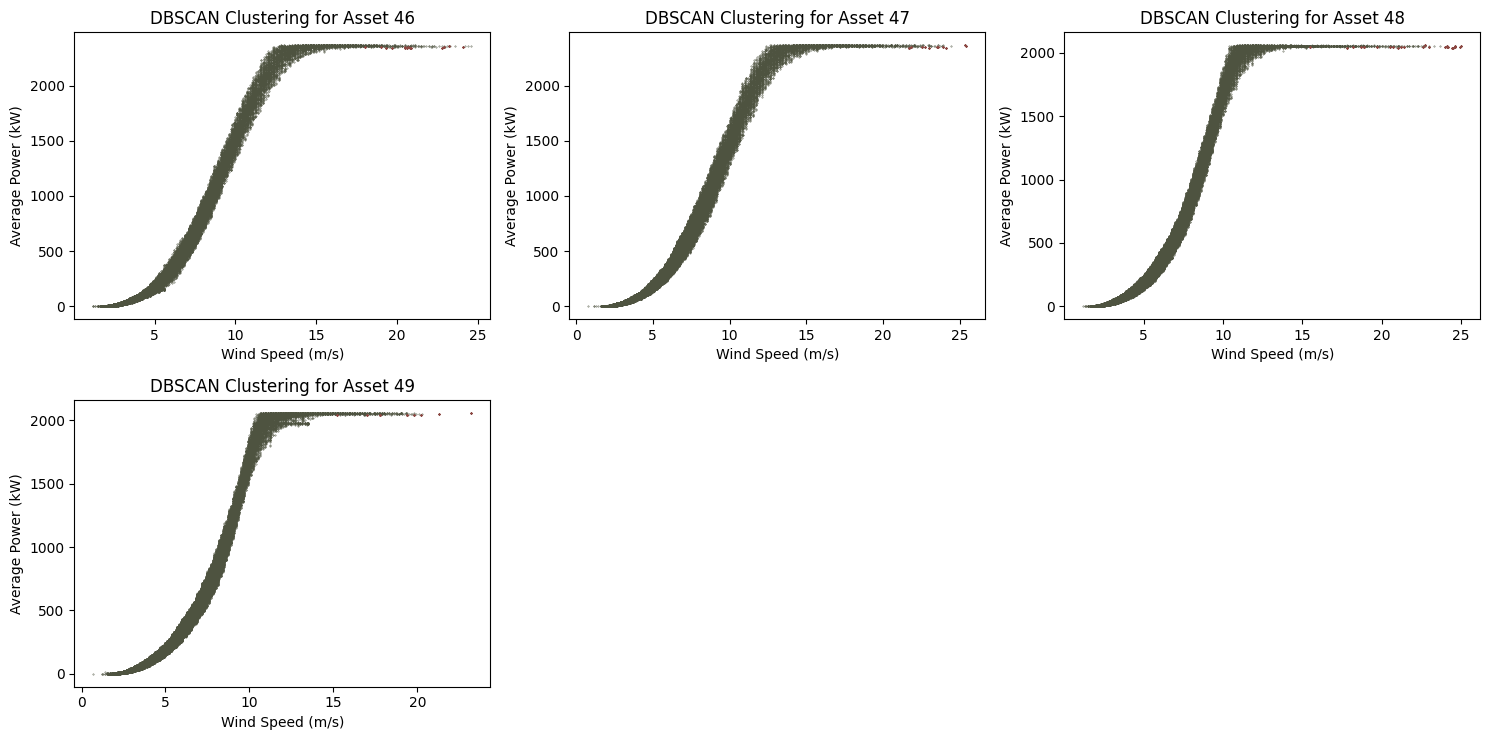

In [84]:
# Define the DBSCAN parameters
eps = 1.5
min_samples = 5

n_plots = 5

plt.figure(figsize=(n_plots*3, n_plots*1.5))

for plot, asset_id in enumerate(df_wind['asset_id'].unique()[32:36], start=1):
    # Filter the data for the current asset
    filtered_data = df_wind[df_wind['asset_id'] == asset_id][['wind_speed', 'power_average']]

    # Create the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the data
    dbscan.fit(filtered_data)

    # Get the labels of the data points
    labels = dbscan.labels_

    # Identify the outliers
    outliers = np.where(labels == -1)[0]

    # Print the number of outliers
    print(f"Number of outliers for Asset {asset_id}:", len(outliers))

    plt.subplot(2, 3, plot)

    # Plot the data with the outliers highlighted
    plt.scatter(filtered_data['wind_speed'], filtered_data['power_average'], c="#4E5340", label = "Remaining Points" , s=0.1)
    plt.scatter(filtered_data.iloc[outliers, 0], filtered_data.iloc[outliers, 1], c="#8C4843", marker="x", label = "Outlier",s=1)
    plt.title(f'DBSCAN Clustering for Asset {asset_id}')
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Average Power (kW)')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Had to do a trade-off in the eps value. if it was smaller, it would take many values that are not outliers

### KLOF

Number of outliers for Asset 11: 59877
Number of outliers for Asset 12: 70325
Number of outliers for Asset 13: 67312
Number of outliers for Asset 14: 69174
Number of outliers for Asset 15: 61255


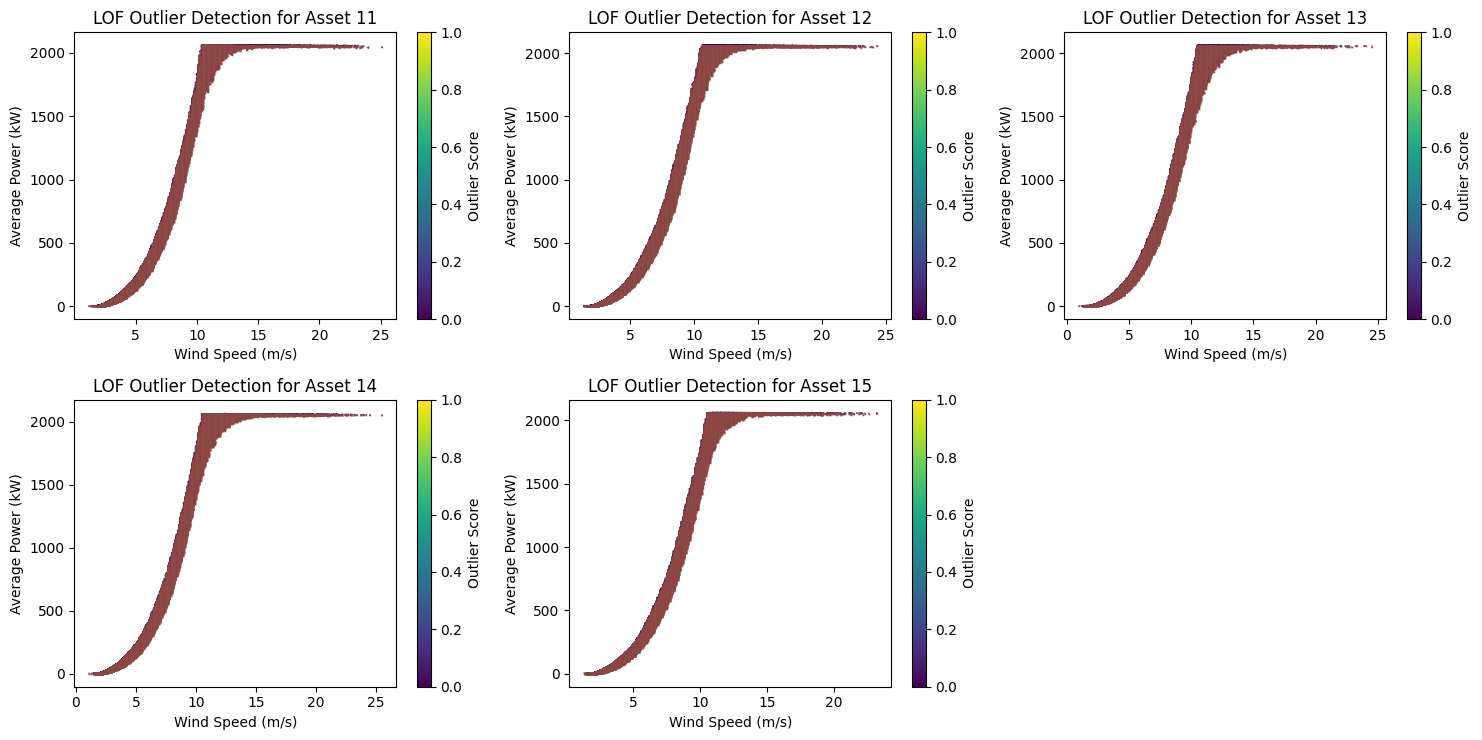

In [85]:
n_plots = 5

plt.figure(figsize=(n_plots*3, n_plots*1.5))

contamination = 0.05

# Iterate over the first 5 assets
for plot, asset_id in enumerate(df_wind['asset_id'].unique()[:n_plots], start=1):
    # Filter the data for the current asset
    filtered_data = df_wind[df_wind['asset_id'] == asset_id][['wind_speed', 'power_average']]

    # Create the LOF model with a kernel function
    lof_model = LOF(contamination=contamination, n_neighbors=5, metric='euclidean', algorithm='auto', leaf_size=30, p=2, n_jobs=1)

    # Fit the model to the data
    lof_model.fit(filtered_data)

    # Predict outliers
    y_train_scores = lof_model.decision_scores_

    # Set a threshold for outliers
    threshold = np.percentile(y_train_scores, 100 * contamination)

    # Identify the outliers
    outliers = np.where(y_train_scores > threshold)[0]

    # Print the number of outliers
    print(f"Number of outliers for Asset {asset_id}:", len(outliers))

    plt.subplot(2, 3, plot)

    # Plot the data with the outliers highlighted
    plt.scatter(filtered_data['wind_speed'], filtered_data['power_average'], c=y_train_scores, cmap='viridis', s=0.1)
    plt.scatter(filtered_data.iloc[outliers, 0], filtered_data.iloc[outliers, 1], c="#8C4843", marker="x", label = "Outlier",s=0.1)
    plt.colorbar(label='Outlier Score')
    plt.title(f'LOF Outlier Detection for Asset {asset_id}')
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Average Power (kW)')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

The best from the 3 is obviously DBSCAN, so we'll apply it to the whole df data set

In [86]:
# Define the DBSCAN parameters
eps = 1.5
min_samples = 5

# Create an empty DataFrame to store the non-outlier data
non_outlier_data = pd.DataFrame()

# Iterate over all assets
for asset_id in df_wind['asset_id'].unique():
    # Filter the data for the current asset
    filtered_data = df_wind[df_wind['asset_id'] == asset_id]

    # Create the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the data
    dbscan.fit(filtered_data[['wind_speed', 'power_average']])

    # Get the labels of the data points
    labels = dbscan.labels_

    # Identify the non-outlier data points
    non_outliers = np.where(labels != -1)[0]

    # Add the non-outlier data points to the DataFrame
    non_outlier_data = pd.concat([non_outlier_data, filtered_data.iloc[non_outliers]], ignore_index=True)

In [87]:
non_outlier_data = non_outlier_data.loc[:,"asset_id":]
non_outlier_data.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1,1
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1,1
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1,1
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1,1
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1,1


In [88]:
non_outlier_data.to_csv('intermediate/wind/final_wind_df.csv', index=False)

In [89]:
original_df_wind = pd.read_csv('intermediate/wind/df_length_to_compare.csv')

In [90]:
non_outlier_data = pd.read_csv('intermediate/wind/final_wind_df.csv')

In [91]:
df_wind_length = len(original_df_wind)
df_wind_without_outliers_length = len(non_outlier_data)

print(df_wind_length)
print(df_wind_without_outliers_length)

6047675
5384535


In [92]:
print(f"{df_wind_length-df_wind_without_outliers_length} lines were considered outliers and removed")
print(f'Which makes for {percent_removed(original_df_wind, non_outlier_data)}% of the data set')

663140 lines were considered outliers and removed
Which makes for 12.32% of the data set


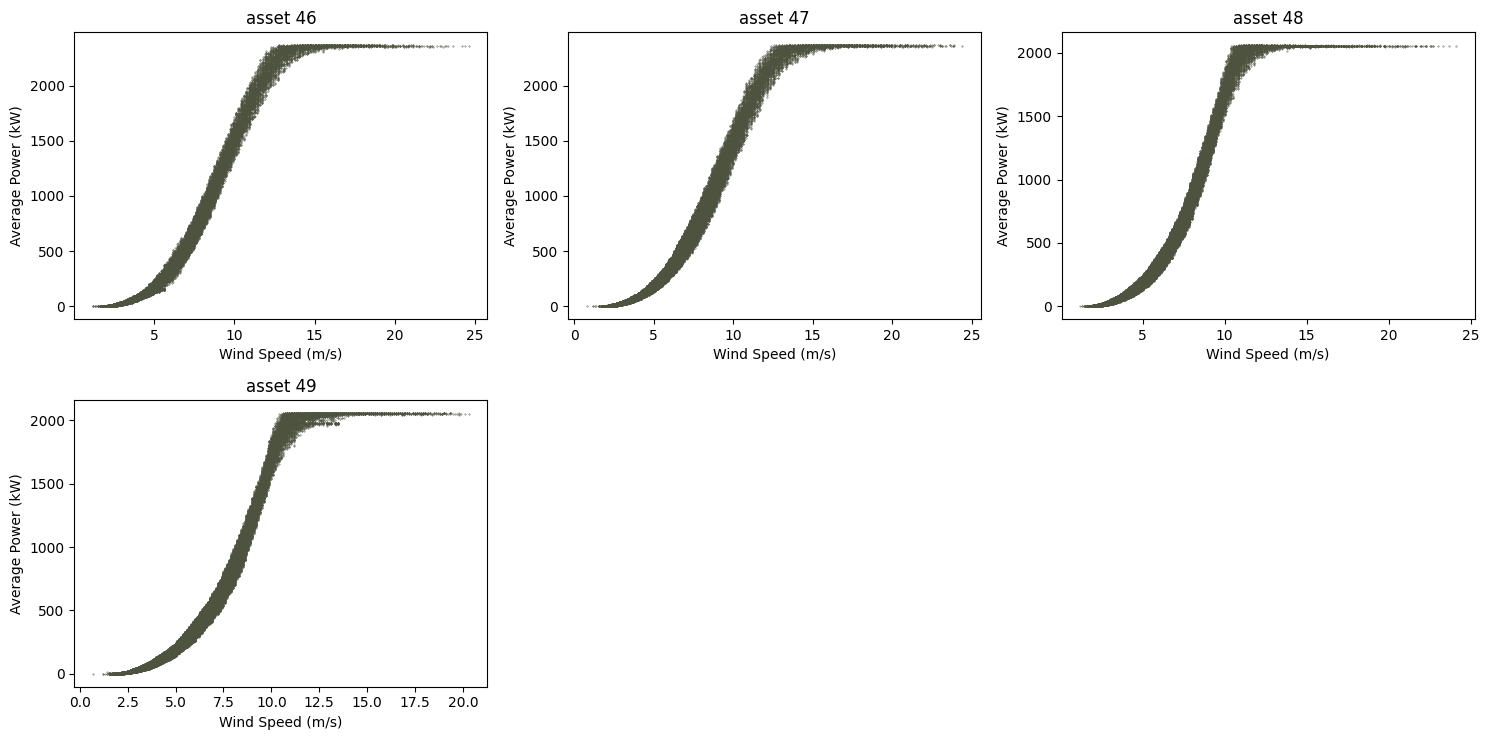

In [93]:
plot = 1
assets = df_wind["asset_id"].unique()[32:36]
n_plots = 5
plt.figure(figsize=(n_plots*3, n_plots*1.5))
for asset, subset in non_outlier_data[non_outlier_data["asset_id"].isin(assets)].groupby("asset_id"):
    plt.subplot(2, 3, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Average Power (kW)')
    plt.scatter(subset["wind_speed"], subset["power_average"], c="#4E5340", s=0.1)
    plot += 1
plt.tight_layout()
plt.show()

#### Store all graphs to check if its working for every asset:

In [94]:
assets = df_wind["asset_id"].unique()
n_plots_per_file = 5
n_assets = len(assets)
n_files = (n_assets - 1) // n_plots_per_file + 1

# Create the output directory if it doesn't exist
output_dir = "intermediate/wind/plots"
os.makedirs(output_dir, exist_ok=True)

# Iterate over each batch of assets
for file_idx in range(n_files):
    start_idx = file_idx * n_plots_per_file
    end_idx = min((file_idx + 1) * n_plots_per_file, n_assets)
    assets_batch = assets[start_idx:end_idx]

    # Plot and save the graphs for the current batch of assets
    plot = 1
    plt.figure(figsize=(n_plots_per_file * 3, n_plots_per_file * 1.5))
    for asset in assets_batch:
        subset = non_outlier_data[non_outlier_data["asset_id"] == asset]
        plt.subplot(2, 3, plot)
        plt.title(f"asset {asset}")
        plt.xlabel('Wind Speed (m/s)')
        plt.ylabel('Average Power (kW)')
        plt.scatter(subset["wind_speed"], subset["power_average"], c="#4E5340", s=0.1)
        plot += 1
    plt.tight_layout()

    # Save the plot to a file
    filename = f'plots_{start_idx + 1}_{end_idx}.png'
    plt.savefig(os.path.join(output_dir, filename))

    # Close the current plot
    plt.close()
